In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 13.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=eeb79b495bc93cc2b328afed13f9e593db0c541ebd233b390512d95fa0150ff0
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 53.9 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
     |████████████████████████████████| 130 kB 31.1 MB/s 
     |████████████████████████████████| 145 kB 63.1 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
     |████████████████████████████████| 748 kB 60.8 MB/s 
     |█████████████████████████████

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Using Pre-Trained Model for Prediction

In [ ]:
imagePath = '/content/drive/Shareddrives/Hackathon - Eleven Strategy/Detection_Train_Set_Img/'

In [ ]:
imagePaths = sorted([os.path.join(imagePath,path) for path in os.listdir(imagePath)])

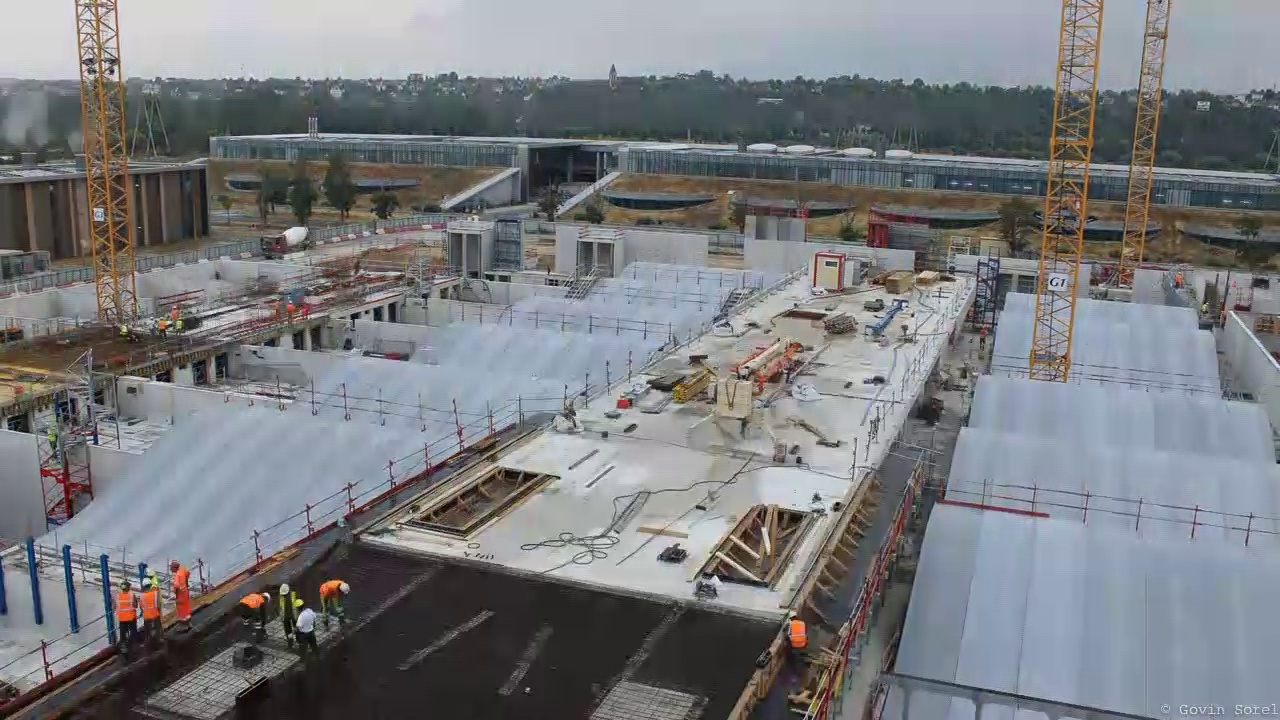

In [ ]:
im = cv2.imread(imagePaths[1])
cv2_imshow(im)

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:08, 20.5MB/s]                           
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[294.3363, 600.9232, 319.0459, 658.8402],
        [319.1330, 576.3343, 348.9459, 617.8633],
        [114.7325, 578.3425, 138.1460, 644.4409],
        [169.0148, 559.3250, 193.2600, 627.4564],
        [278.1042, 582.4780, 296.4384, 647.6168],
        [140.3517, 579.0944, 162.5695, 640.9091]], device='cuda:0'))


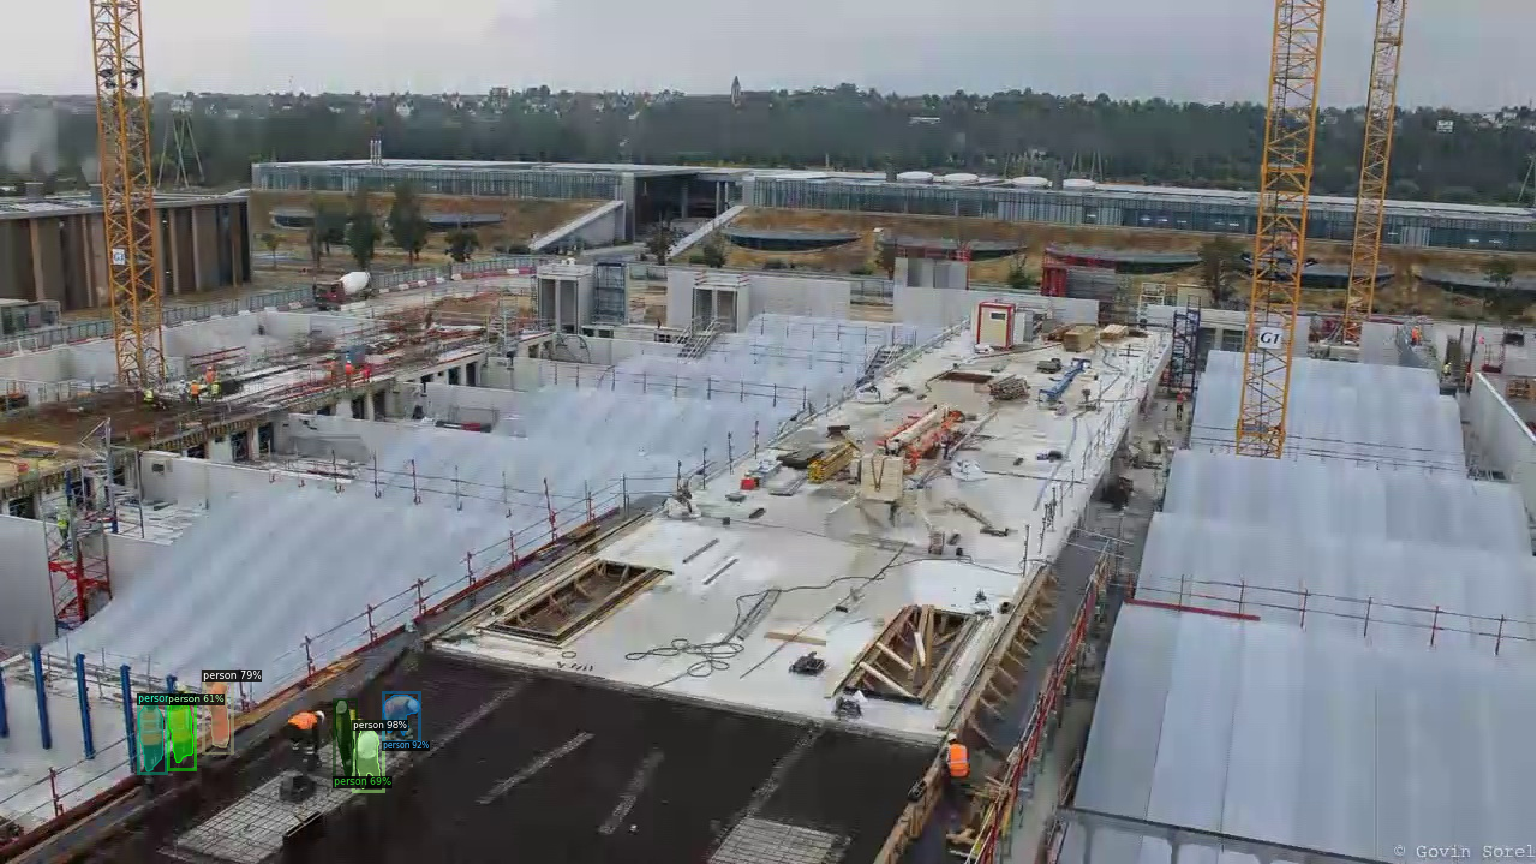

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

### Training Existing Model on New Data

In [ ]:
# Prepare data and register for training
from detectron2.structures import BoxMode

def get_people_dicts(data_dir):
    # Get all image names
    img_dir = os.path.join(data_dir, "Detection_Train_Set_Img")
    files = os.listdir(img_dir)

    dataset_dicts = []

    for idx, file in enumerate(files):

        json_file = os.path.join(data_dir, "Detection_Train_Set_Json", file+".json")
        if os.path.isfile(json_file):
            with open(json_file) as f:
                img_anns = json.load(f)
            
            record = {}

            filename = os.path.join(data_dir, "Detection_Train_Set_Img", file)
            height, width = cv2.imread(filename).shape[:2]

            record["file_name"] = filename
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width

            objs = []
            for anno in img_anns['objects']:
                if anno['classTitle'] == 'People':
                    x_min, x_max = anno['points']['exterior'][0][0], anno['points']['exterior'][1][0]
                    y_min, y_max = anno['points']['exterior'][0][1], anno['points']['exterior'][1][1]
                    obj = {
                        "bbox": [x_min, y_min, x_max, y_max],
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "segmentation": [[x_min,y_min,x_max,y_min,x_max,y_max,x_max,y_min]],
                        "category_id": 0,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        else: print("Missing JSON File: {}".format(file))
      
    return dataset_dicts

DatasetCatalog.register("people_train", lambda : get_people_dicts("gdrive/MyDrive/Hackathon/data/Detection_Train_Set/"))
MetadataCatalog.get("people_train").set(thing_classes=["people"])
people_metadata = MetadataCatalog.get("people_train")

### Train

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("people_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[02/16 11:54:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[02/16 12:07:13 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[02/16 12:07:23 d2.utils.events]:  eta: 0:02:15  iter: 19  total_loss: 2.816  loss_cls: 0.6563  loss_box_reg: 0.2245  loss_mask: 0.6938  loss_rpn_cls: 0.8275  loss_rpn_loc: 0.2954  time: 0.4898  data_time: 0.0224  lr: 1.6068e-05  max_mem: 2936M
[02/16 12:07:33 d2.utils.events]:  eta: 0:02:06  iter: 39  total_loss: 1.982  loss_cls: 0.5613  loss_box_reg: 0.3052  loss_mask: 0.6585  loss_rpn_cls: 0.1987  loss_rpn_loc: 0.2352  time: 0.4925  data_time: 0.0085  lr: 3.2718e-05  max_mem: 2936M
[02/16 12:07:43 d2.utils.events]:  eta: 0:01:59  iter: 59  total_loss: 1.955  loss_cls: 0.4317  loss_box_reg: 0.2594  loss_mask: 0.5815  loss_rpn_cls: 0.2222  loss_rpn_loc: 0.3234  time: 0.4975  data_time: 0.0073  lr: 4.9367e-05  max_mem: 2936M
[02/16 12:07:53 d2.utils.events]:  eta: 0:01:50  iter: 79  total_loss: 2.023  loss_cls: 0.3908  loss_box_reg: 0.4114  loss_mask: 0.4826  loss_rpn_cls: 0.2271  loss_rpn_loc: 0.3467  time: 0.4966  data_time: 0.0068  lr: 6.6017e-05  max_mem: 2936M
[02/16 12:08:03 d2.u

### Making Predictions

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
dataset_dicts = get_people_dicts("gdrive/MyDrive/Hackathon/data/Detection_Train_Set/")

Missing JSON File: Batch2__Roissy_02frame928.jpg
Missing JSON File: Batch2__Roissy_02frame926.jpg


In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 10):

    im = cv2.imread(d["file_name"])

    # Plot Ground Truth
    visualizer = Visualizer(im[:, :, ::-1], metadata=people_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

    # Plot Predictions  
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=people_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

### Evaluating Performance Using AP Metric

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("people_train", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "people_train")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[02/16 12:10:34 d2.evaluation.coco_evaluation]: Trying to convert 'people_train' to COCO format ...
[02/16 12:10:34 d2.data.datasets.coco]: Converting annotations of dataset 'people_train' to COCO format ...)
Missing JSON File: Batch2__Roissy_02frame928.jpg
Missing JSON File: Batch2__Roissy_02frame926.jpg
[02/16 12:11:15 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/16 12:11:17 d2.data.datasets.coco]: Conversion finished, #images: 1557, #annotations: 11664
[02/16 12:11:17 d2.data.datasets.coco]: Caching COCO format annotations at './output/people_train_coco_format.json' ...
Missing JSON File: Batch2__Roissy_02frame928.jpg
Missing JSON File: Batch2__Roissy_02frame926.jpg
[02/16 12:11:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/16 12:11:57 d2.data.common]: Serializing 1557 elements to byte tensors and concatenating them all ...
[02/16 12:11

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[02/16 12:11:59 d2.evaluation.evaluator]: Inference done 11/1557. Dataloading: 0.0016 s/iter. Inference: 0.1145 s/iter. Eval: 0.0242 s/iter. Total: 0.1402 s/iter. ETA=0:03:36
[02/16 12:12:04 d2.evaluation.evaluator]: Inference done 48/1557. Dataloading: 0.0020 s/iter. Inference: 0.1135 s/iter. Eval: 0.0221 s/iter. Total: 0.1378 s/iter. ETA=0:03:27
[02/16 12:12:09 d2.evaluation.evaluator]: Inference done 85/1557. Dataloading: 0.0020 s/iter. Inference: 0.1139 s/iter. Eval: 0.0211 s/iter. Total: 0.1370 s/iter. ETA=0:03:21
[02/16 12:12:14 d2.evaluation.evaluator]: Inference done 122/1557. Dataloading: 0.0020 s/iter. Inference: 0.1140 s/iter. Eval: 0.0206 s/iter. Total: 0.1367 s/iter. ETA=0:03:16
[02/16 12:12:19 d2.evaluation.evaluator]: Inference done 158/1557. Dataloading: 0.0020 s/iter. Inference: 0.1145 s/iter. Eval: 0.0208 s/iter. Total: 0.1374 s/iter. ETA=0:03:12
[02/16 12:12:24 d2.evaluation.evaluator]: Inference done 195/1557. Dataloading: 0.0020 s/iter. Inference: 0.1148 s/iter. Ev